Integrantes

* Diana Díaz - Cod. 201331684
* Carlos Silva - Cod. 201920463 
* Javier Lesmes - Cod. 200820243

# Cargue de librerías a usar

In [254]:
#Librerias par el procesamiento de los datos
import pandas as pd
import numpy as np
from scipy import stats
from scipy.integrate import trapz
#Librerias para visuzalización gráfica
import matplotlib.pyplot as plt
import seaborn as sns
#Librerias para el procesamiento de texto
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
#Librerias para el entrenamiento del modelo
from sklearn.metrics import  roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#Librerías para la exportación del modelo
import joblib
import pickle

# Preprocesamiento
## Cargue de la información de training y de test

In [255]:
dataTraining = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [256]:
dataTraining.head(2)

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6


In [257]:
dataTraining.shape

(7895, 5)

La data de training cuenta con información de 7.895 peliculas y 5 caracteristicas que son: year, title, plot, genres y ratingLa data de training cuenta con información de 7.895 peliculas y 5 caracteristicas que son: year, title, plot, genres y rating

In [258]:
dataTesting.head(2)

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."


In [259]:
dataTesting.shape

(3383, 3)

La data de testing cuenta con tres variables que son: year, title y plot.a data de testing cuenta con tres variables que son: year, title y plot.

# Análisis Descriptivo del Dataset

## Análisis de la variable de respuesta: **Género (genres)**

In [260]:
dataTraining.genres.describe()

count          7895
unique         1336
top       ['Drama']
freq            429
Name: genres, dtype: object

### Identificación de **géneros distintos**
Una pelicula puede estar clasificada en más de un genero, de manera que hay 1336 combinaciones de 26 géneros distintos, siendo los más frecuentes el drama (50%), la comedia(38.6%), los thriller(25.6%), el romance (23.9%) y crimen (18.3%). A partir de esto, consideramos la creación de una variable que indique cuántos género tiene una pelicula. 

In [261]:
g = CountVectorizer() # utilizamos el counvectorizer en este paso únicamente para abrir la variable genres en categorías.
g_dtm = g.fit_transform(dataTraining['genres'])
g_temp=g_dtm.todense()
generos = pd.DataFrame(g_temp, columns=g.get_feature_names())
generos.iloc[:5,:6]

,action,adventure,animation,biography,comedy,crime
0,0,0,0,0,0,0
1,0,0,0,0,1,1
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,1,0,0,0,0,1


In [262]:
generosT = generos.sum(axis=0) 
generosT = pd.DataFrame(generosT)
generosT.reset_index(level=0, inplace=True)
generosT.columns = ['Generos', 'value']
generosT['Porcentaje']=generosT['value']/7895*100
generosT=generosT.sort_values(by=['Porcentaje'])
generosT.tail()

,Generos,value,Porcentaje
5,crime,1447,18.328056
19,romance,1892,23.964535
23,thriller,2024,25.636479
4,comedy,3046,38.581381
7,drama,3965,50.221659


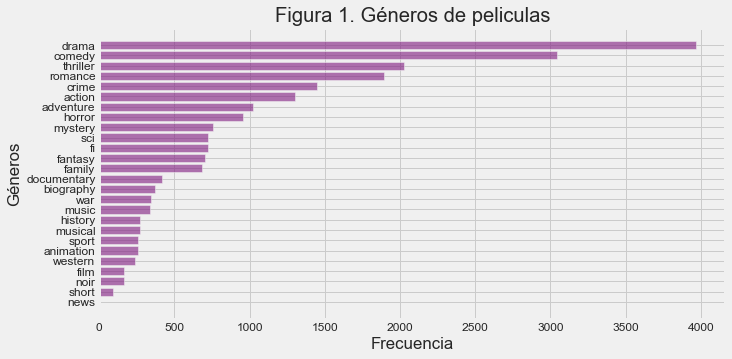

In [263]:
%matplotlib inline
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize = (10, 5)) 
plt.title('Figura 1. Géneros de peliculas');
plt.barh(generosT["Generos"], generosT["value"], color = (0.5,0.1,0.5,0.6));
plt.ylabel('Géneros');
plt.xlabel('Frecuencia');

In [264]:
df =generos.copy()
df.index = dataTraining.index # se asigna el indice de datatraining a generos
df= df.sum(axis=1) # suma de generos por película
df=pd.DataFrame(df)
df.columns = ["T_generos"]
dataTraining=pd.concat([dataTraining, df], axis=1)

## Número de peliculas por año
La serie de tiempo del número de peliculas por año (1.894 y 2.015), evidencia que el número de peliculas tiene una tendencia creciente con relación al aumento del tiempo. A partir de esto y del gráfico anterior (Gráfico de dispersión del año por el rating)se considera que puede contribuir en el análisis la creación de una variable que indique la antiguedad de la pelicula.


In [265]:
dataTraining.year.min(), dataTraining.year.max()

(1894, 2015)

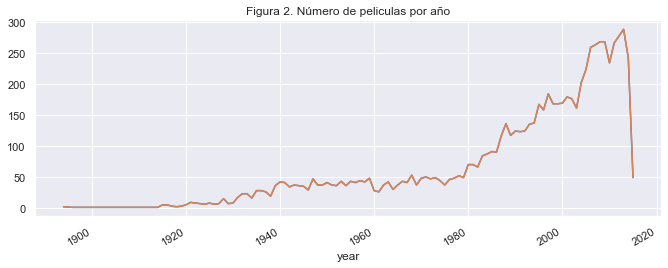

In [266]:
%matplotlib inline
sns.set()
moviexyear=dataTraining['year'].value_counts()
moviexyear=pd.DataFrame(moviexyear)
moviexyear.reset_index(level=0, inplace=True)
moviexyear.columns = ['year','Peliculas']
moviexyear.index = pd.to_datetime(moviexyear['year'] , format='%Y')
moviexyear=moviexyear["Peliculas"]
moviexyear.plot(figsize=(10, 4))
moviexyear.plot();
plt.title('Figura 2. Número de peliculas por año');

**Nueva variable: antiguedad**
Como se aprecia en el gráfico de densidad de la variable antiguedad, es una variable sesgada a la derecha confirmando lo presentado en el gráfico de serie de tiempo, que nos mostró que las películas son producciones recientes. 

In [267]:
dataTraining['antiguedad']=2015-dataTraining['year']
dataTraining.antiguedad.describe()

count    7895.000000
mean       25.273591
std        22.660717
min         0.000000
25%         8.000000
50%        18.000000
75%        35.000000
max       121.000000
Name: antiguedad, dtype: float64

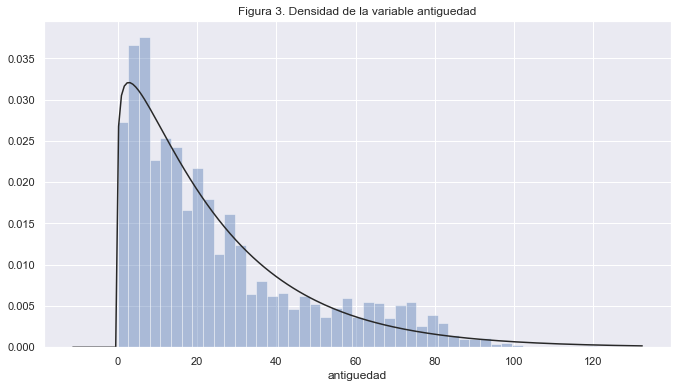

In [268]:
from scipy.integrate import trapz
from scipy import stats
x=dataTraining['antiguedad']
fig = plt.figure(figsize = (10, 6))
plt.title('Figura 3. Densidad de la variable antiguedad')
sns.distplot(x, kde=False, fit=stats.gamma);

## Gráfico Dispersión de Antiguedad por Número de géneros:
Acá observamos que una película no es clasificada con más de 10 géneros y  que son pocas las películas con más de 6 géneros. 

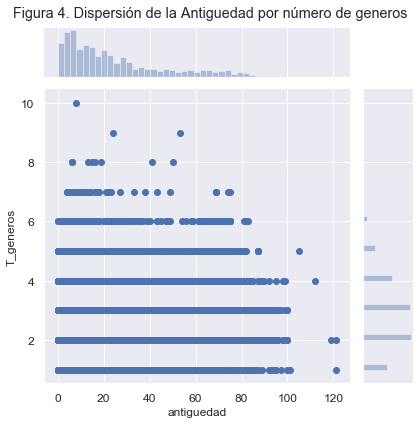

In [276]:
p = sns.jointplot(x="antiguedad", y="T_generos", data=dataTraining, height=4);
p.fig.suptitle('Figura 4. Dispersión de la Antiguedad por número de generos')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.93)

# Procesamiento del texto para el modelo clasificador
Inicialmente procedemos a juntar el titulo y la trama y luego unimos los datasets de train y test, esto con el fin de realizar un procesamiento conjunto. Luego, procedemos a quitar algunos caracteres como ",, ".", "-" y  "_". Adicionalmente, juntamos también las variables de año que usaremos mas adelante como información adicional para el modelo.


In [170]:
dataTraining['uno']= dataTraining['title']+dataTraining['plot']
dataTesting['uno'] = dataTesting['title']+dataTesting['plot']
dat = dataTraining['uno'].append(dataTesting['uno'])
years = dataTraining['year'].append(dataTesting['year'])
dat=dat.str.lower()
dat=dat.str.replace(',', '') 
dat=dat.str.replace('.', '') 
dat=dat.str.replace('-', '') 
dat=dat.str.replace('_', '')
trsize = dataTraining.shape[0]

Creamos una función para convertir a minúsculas, partir el texto por espacios y hacer lematización.

In [171]:
wordnet_lemmatizer = WordNetLemmatizer()
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word, 's') for word in words]

Hacemos TFDF al texto usando la función anterior como lematizador y con los siguientes parámetros:
* **min_df = 2**. Especificamos que la palabra a usar tiene que estar si o si en al menos 2 title+plot de cada pelicula
* **max_features = 25564**. Definimos manualmente el tamaño máximo de vocabularios
* **sublinear_tf = True**. Aplicamos un escalado sublineal, es decir, el valor de cada palabra no va a ser tf sino 1+log(tf)
* **strip_accents='unicode'*. Removemos otros caracteres extraños que se nos hayan quedado
* **ngram_range=(1,3)**. Obtenemos unigramas, bigramas y trigramas solamente.
* **stop_words='english'**. Removemos stop stop_words

Adicionalmente, agregamos el año para que sea tenido en cuenta en la regresión.

In [172]:
vect = TfidfVectorizer(analyzer=split_into_lemmas,
                        min_df=2,
                        max_features=None,
                        sublinear_tf=True,
                       strip_accents='unicode',
                       ngram_range=(1,1),
                       stop_words='english')
X_dtm = vect.fit_transform(dat, years)

Habiendo procesado el texto ya, procedemos a separar la base de train y de test/submission

In [173]:
X_dtm_test = X_dtm[trsize:,:]
X_dtm = X_dtm[:trsize,:]

Ahora creamos la variable a predecir

In [174]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

Abrimos la información de train en train y test, dejando el 30% de los datos para test. Dejamos una semilla estática para replicar el proceso.

In [175]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.2, random_state=666)

# Entrenando modelo Multiclase, Multilabel

El modelo seleccionado fue una regresión logística Ridge multinomial, calculando su máxima verosimilitud empleando el método de Newton, con un inverso de fuerza de regularizacion de 1.5 (Encontrado mediante GridSearch y al igual que en las SVM, los valores más pequeños especifican una regularización más fuerte) y entrenando en paralelo cada una de estas por cada genero de película a predecir. Dejamos una semilla para replicar los resultados y ajustamos la tolerancia a 1e-7.

In [176]:
LogReg_Model = OneVsRestClassifier(LogisticRegression(multi_class='multinomial',
                                                      solver='newton-cg',
                                                      C=1.5,
                                                      penalty='l2',
                                                      random_state=666,
                                                      tol=1e-7),
                                                n_jobs=-1)
LogReg_Model.fit(X_train, y_train_genres);

Realizamos la predicción del modelo con los datos de test y revisamos su AUC Score. Debido a que son 24 probabilidades independientes, tenemos que adicionar el parametro **average='macro'**, esto para que calcule de forma individual el AUC de cada género y luego los promedie.

In [177]:
y_pred_genres = LogReg_Model.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.89869525049798

Obtenemos un AUC Score en test de 0.90, el cual es un muy buen resultado, ahora procederemos a usar el modelo en la data de test/submission para el Kaggle Competition

In [204]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']
y_pred_test_genres = LogReg_Model.predict_proba(X_dtm_test)
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.iloc[:5,:6]

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime
1,0.128560,0.064312,0.020640,0.018304,0.324935,0.107494
4,0.120500,0.037599,0.030231,0.107796,0.253010,0.300421
5,0.049758,0.015901,0.005965,0.052074,0.101991,0.722853
6,0.103296,0.112497,0.011151,0.042817,0.112311,0.056685
7,0.022366,0.034215,0.016932,0.028521,0.143102,0.077118


In [120]:
res.to_csv('submission.csv', index_label='ID')

# Generación del modelo para el API
Ahora, procederemos a exportar nuestros modelo y parámetros adicionales para la implementación del API
Comenzamos exportando nuestro modelo

In [179]:
joblib.dump(LogReg_Model, 'api/model_logit.pkl', compress=3)

['api/model_logit.pkl']

Luego, exportamos el vocabulario generado en el TFDF, esto con el fin de replicar el mismo procesamiento del texto en el api

In [180]:
with open("api/vocabulary.txt", "wb") as fp:
  pickle.dump(vect.vocabulary_, fp)

Y para finalizar, generamos una función que encuentre el Threshold óptimo para cada género a predecir y los exportamos. Al final, nuestro modelo no dirá la probablidad sino ya la predicción de los géneros a los cual clasificá la película

In [181]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[0],:]
    return roc_t['threshold']

th = np.zeros(len(cols))

for i in range(0,len(cols)):
    th[i] = Find_Optimal_Cutoff(y_test_genres[:,i], y_pred_genres[:,i])

with open("api/th.txt", "wb") as fp:
  pickle.dump(th, fp)

# Conclusiones
* Poder lograr una solución robusta con modelos sencillos es todo un éxito ya que la facilidad de interpretación como en la implementación (sin dejar de un lado el costo del cálculo computacional) hace que nos sintamos satisfechos con los resultados obtenidos.
* Antes de realizar cualquier tipo de modelo analítico, es necesario realizar un análisis descriptivo y conocer a fondo el dataset, esto con el fin de familizarse mucho mas rapido con la información, asi como entender con más facilidad las posibles complicaciones al implementar los distintos modelos.
* Se revisaron muchos modelos antes de elegir la regresion logistica lasso multinomial buscando obtener mejores resultados (SVC, Random Forest Classifier, MLP con LSTM, XGBoost Classifier, Extra Trees Classifier, etc) pero la limitante en cantidad de registros (7000 peliculas de las cuales tocaba aislar algunas para test) como también, el desbalanceo enorme entre clases, afectaba de forma drástica los modelos mas complejos.

* A partir del análisis realizado a los datos, inicialmente se consideró oportuno incluir en la estimación la variable creada que se denominó “Antigüedad”, la cual fue de utilidad para entender aún mas la información, sin embargo, después de revisar los resultados de algunas estimaciones y teniendo en cuenta que ya se tenía la variable año para cada película, finalmente no se incluyó en la regresión.